In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from datetime import datetime
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from models import MLP, CNN_MNIST
from utils import test

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))

Using cuda device


In [2]:
train_data = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform=ToTensor()
)

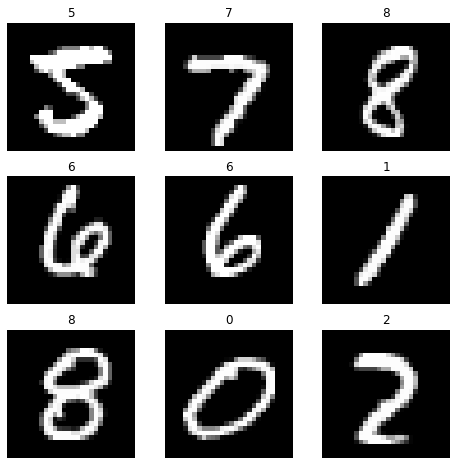

In [3]:
fig = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

In [4]:
BATCH_SIZE = 64
HIDDEN_DIM = 64
NB_EPOCHS = 10
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [5]:
def train(dataloader, model, loss_function, optimizer):

    model.train()

    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_function(y_pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print('[{}/{}] loss: {}'.format(batch*len(X), size, loss))


In [6]:
# model = MLP().to(device)
model = CNN_MNIST().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [7]:
test(test_dataloader, model, loss_function, device)
for e in range(1, NB_EPOCHS+1):
    print(f'Epoch {e}/{NB_EPOCHS}\n-------------------')
    train(train_dataloader, model, loss_function, optimizer)
    test(test_dataloader, model, loss_function, device)

Test error: 2.306816577911377
Accuracy 0.0897

Epoch 1/10
-------------------
[0/60000] loss: 2.42163348197937
[6400/60000] loss: 0.21789871156215668
[12800/60000] loss: 0.04488047957420349
[19200/60000] loss: 0.17090369760990143
[25600/60000] loss: 0.20457248389720917
[32000/60000] loss: 0.20471735298633575
[38400/60000] loss: 0.13183212280273438
[44800/60000] loss: 0.16221387684345245
[51200/60000] loss: 0.24998050928115845
[57600/60000] loss: 0.014788059517741203
Test error: 0.1450132578611374
Accuracy 0.9566

Epoch 2/10
-------------------
[0/60000] loss: 0.19913502037525177
[6400/60000] loss: 0.11922206729650497
[12800/60000] loss: 0.04388139769434929
[19200/60000] loss: 0.03224058076739311
[25600/60000] loss: 0.02679484337568283
[32000/60000] loss: 0.01779160089790821
[38400/60000] loss: 0.1695316731929779
[44800/60000] loss: 0.053226783871650696
[51200/60000] loss: 0.11795534193515778
[57600/60000] loss: 0.0191427581012249
Test error: 0.058285921812057495
Accuracy 0.9805

Epoch 

In [50]:
torch.save(model.state_dict(), f'./models/CNN_MNIST_weights_{datetime.now().strftime("%Y%m%d_%H%M")}.pth')

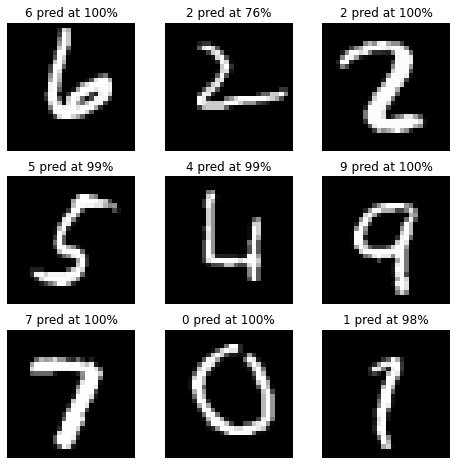

In [47]:
model.eval()

fig = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    
    x = img.unsqueeze(0).to(device)
    proba = int(100*F.softmax(model(x), dim=1)[0, label])
    
    fig.add_subplot(rows, cols, i)
    plt.title(f'{label} pred at {proba}%')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')